# Ejemplo de Identificación de Sistemas
*Ignacio Díaz Blanco, 2019-2023. Universidad de Oviedo.*

En este ejemplo se muestra el proceso de identificación de un sistema lineal discreto. La identificación puede plantearse como un problema de regresión multivariable, que puede resolverse utilizando funciones de la librería `scikit-learn`. 

Algunas variantes que el alumno puede probar, para observar los resultados, son las siguientes:

* modificar el sistema de test, 
* variar el ruido añadido 
* o modificar el parámetro $\alpha$ de regularización.


In [1]:
from scipy.signal import lfilter
from numpy.random import randn
from numpy import hstack, array, arange, sin
import matplotlib.pyplot as plt

%matplotlib inline

### Generación de datos de entrenamiento
En este bloque excitamos el siguiente sistema dinámico:

$$
G(z) = \frac{1+2z^{-1}}{1-z^{-1}+0.9z^{-2}} \qquad \longleftrightarrow \qquad y_k = u_k + 2 u_{k-1} + y_{k-1} - 0.9 y_{k-2}
$$

con una señal de excitación aleatoria (ruido blanco gaussiano). La excitación mediante ruido blanco es muy rica en información; excita todos los modos del sistema, lo que hace que el problema minimo-cuadrático esté bien condicionado y no de lugar a soluciones degeneradas. A la capacidad de una señal para excitar un sistema y producir soluciones bien condicionadas se la denomina *persistencia en la excitación*.


Text(0.5, 1.0, 'salida $y_k$ (entrenamiento)')

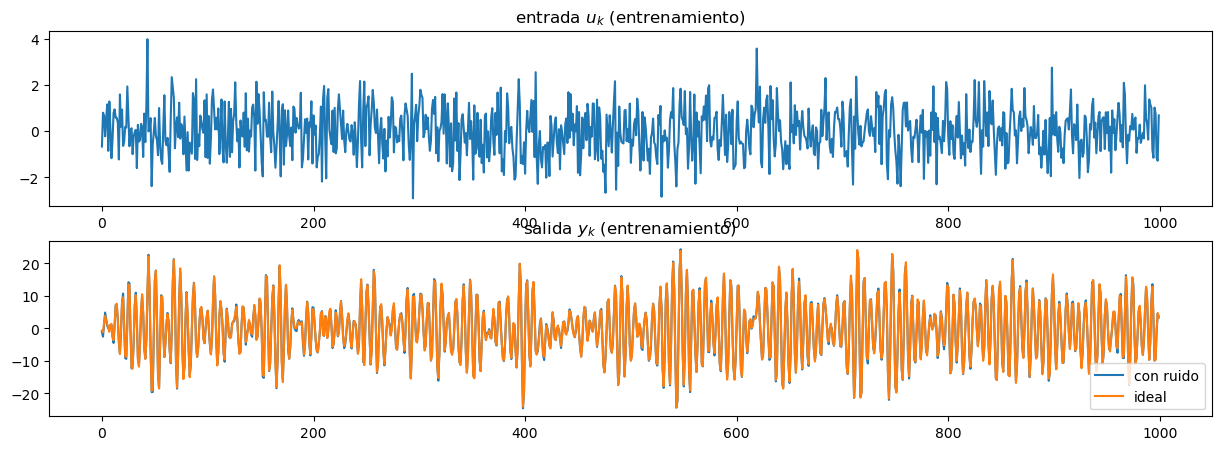

In [2]:
# Número total de muestras
N = 1000

# Numerador y denominador de la función de transferencia discreta
numz = [1,2]
denz = [1,-1,0.9]

# Excitamos el sistema mediante una perturbación aleatoria
uk = randn(N)
yk = lfilter(numz,denz,uk) + 0.5*randn(N)

# Mostramos los resultados
plt.figure(1,figsize=(15,5))
plt.subplot(2,1,1)
plt.plot(uk)
plt.title('entrada $u_k$ (entrenamiento)')

plt.subplot(2,1,2)
plt.plot(yk)
plt.plot(lfilter(numz,denz,uk))
plt.legend(['con ruido','ideal'])
plt.title('salida $y_k$ (entrenamiento)')

### Generación de datos de test
Generaremos ahora un conjunto de datos de test. Someteremos nuestro sistema $G(z)$ a otra señal de entrada diferente (en este caso, cuadrada), que no hemos utilizado en la estimación del modelo.

Text(0.5, 1.0, 'salida $y_k$ (test)')

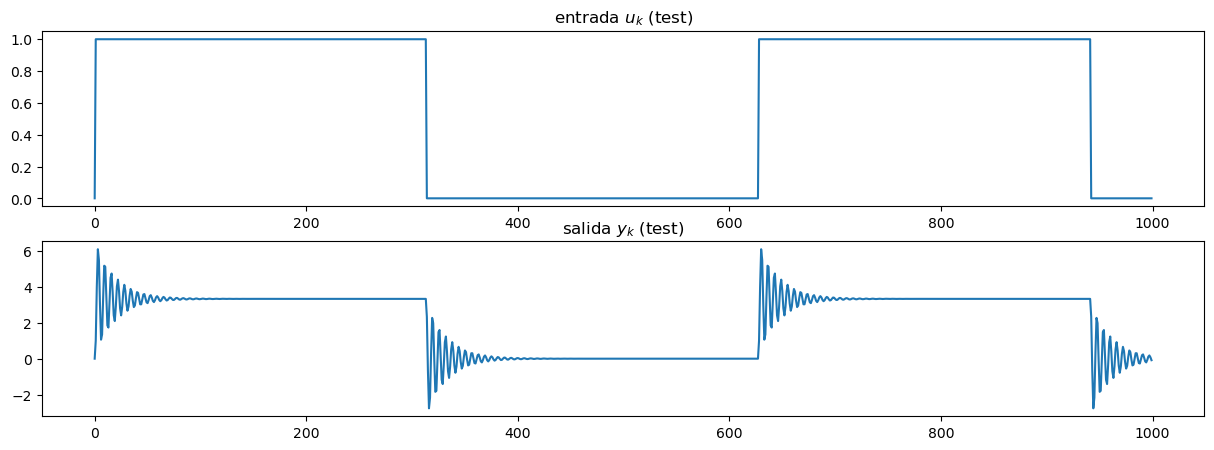

In [3]:
# Tamaño del conjunto de test
Q = 1000

# Excitamos el sistema mediante una señal cuadrada
from numpy import square, linspace
utst = sin(linspace(0,10,Q))>0
ytst = lfilter(numz,denz,utst)

# Mostramos la respuesta
plt.figure(1,figsize=(15,5))
plt.subplot(2,1,1)
plt.plot(utst)
plt.title('entrada $u_k$ (test)')


plt.subplot(2,1,2)
plt.plot(ytst)
plt.title('salida $y_k$ (test)')


### Problema de identificación en términos de regresión multivariable
El problema puede formalizarse en términos de una regresión multivariable. La matriz $X$ de regresores, contendrá valores de la entrada y de la salida con distintos retardos, de forma que el producto de $X$ por una matriz de coeficientes del modelo den lugar a la salida en el instante actual. En general,
$$
\begin{bmatrix}
\vdots \\
y(k) \\
\vdots
\end{bmatrix} 
= 
\begin{bmatrix}
       &        & \vdots &      &        &       \\
y(k-1) & \cdots & y(k-n) & u(k) & \cdots & u(k-m)\\
       &        & \vdots &      &        &       \\
\end{bmatrix}
\begin{bmatrix}
-a_1 \\
\vdots \\
-a_n \\
b_0 \\
\vdots \\
b_m
\end{bmatrix}
$$

$$
\mathbf Y = \mathbf X\mathbf W
$$

In [4]:
# función para la construcción de la matriz X con las entradas y salidas retardadas
def tddata(uk,yk,AR,MA):
    Q = len(yk)
    X = []
    y = []
    
    idxu = arange(0,MA+1)
    idxy = arange(1,AR+1)
    # print idxu, idxy
    for k in range(AR+1,Q):
        X.append(hstack((
                    uk[k-idxu],
                    yk[k-idxy]
                )).tolist()  )
        y.append(yk[k].tolist() )
    return X,y

X,y = tddata(uk,yk,2,1)

Xtst,ytst = tddata(utst,ytst,2,1)

X = array(X)
y = array(y)
Xtst = array(Xtst)
ytst = array(ytst)


### Solución empleando la librería <code>scikit-learn</code>
Resolvemos el problema utilizando la librería `scikit-learn`. Utilizaremos las funciones para normalización `MinMaxScaler()` y de estimación lineal mínimo-cuadrática `linear_model.Ridge()`, de tipo *ridge regression*, con factor regularización $\alpha$ 

#### Normalización

In [5]:
print(X.shape,y.shape,Xtst.shape,ytst.shape)

(997, 4) (997,) (997, 4) (997,)


In [6]:
# NORMALIZACIÓN DE LAS VARIABLES
from sklearn.preprocessing import MinMaxScaler

# Creamos una clase de normalización
minmaxx = MinMaxScaler(feature_range=(-1,1))

# Aplicamos método fit para calcular la normalización (hallar máximos y mínimos)
minmaxx.fit(X)

# Aplicamos la normalización a los datos de entrenamiento y a los de test
X_norm    = minmaxx.transform(X)
Xtst_norm = minmaxx.transform(Xtst)

# Creamos una clase de normalización para las salidas
minmaxy = MinMaxScaler(feature_range=(-1,1))


# NORMALIZACIÓN DE LAS SALIDAS
# Aplicamos método fit para calcular la normalización (hallar máximos y mínimos) 
minmaxy.fit(y[:,None])

# Aplicamos la normalización a los datos de entrenamiento y a los de test
y_norm    = minmaxy.transform(y[:,None])
ytst_norm = minmaxy.transform(ytst[:,None])

#### Estimación del modelo lineal

In [7]:
# PREDICCIÓN LINEAL
from sklearn import linear_model
clf = linear_model.Ridge (alpha = 0.0)
clf.fit(X_norm,y_norm)
yest_norm = clf.predict(Xtst_norm)

### Representación de los resultados (real vs. estimado)

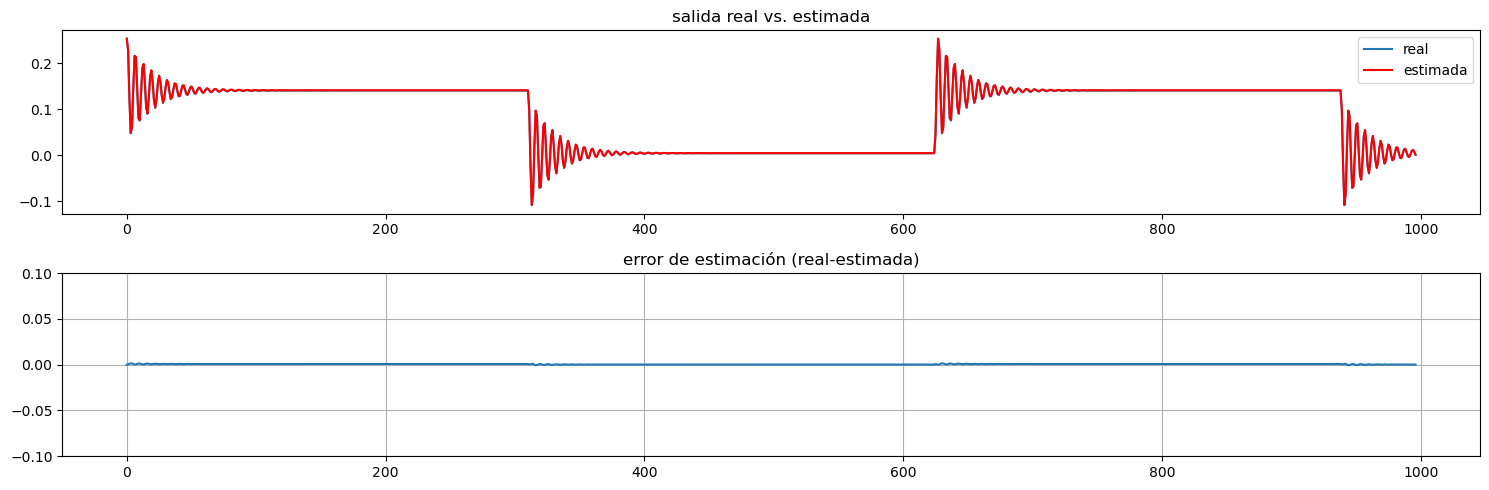

In [8]:
plt.figure(1,figsize=(15,5))
plt.clf()
plt.subplot(2,1,1)
plt.plot(ytst_norm)
plt.plot(yest_norm,'r')
plt.legend(['real','estimada'])
plt.title(u'salida real vs. estimada')

plt.subplot(2,1,2)
plt.plot(yest_norm-ytst_norm)
plt.axis(ymin=-0.1,ymax=0.1)
plt.grid(True)
plt.title(u'error de estimación (real-estimada)')
plt.tight_layout()




coeficientes reales vs estimados
numerador:   	 [1, 2] 	 numerador (estim):    [1.         1.98340781]
denominador: 	 [1, -1, 0.9] 	 denominador (estim):  [ 1.         -0.99312348  0.89334742]


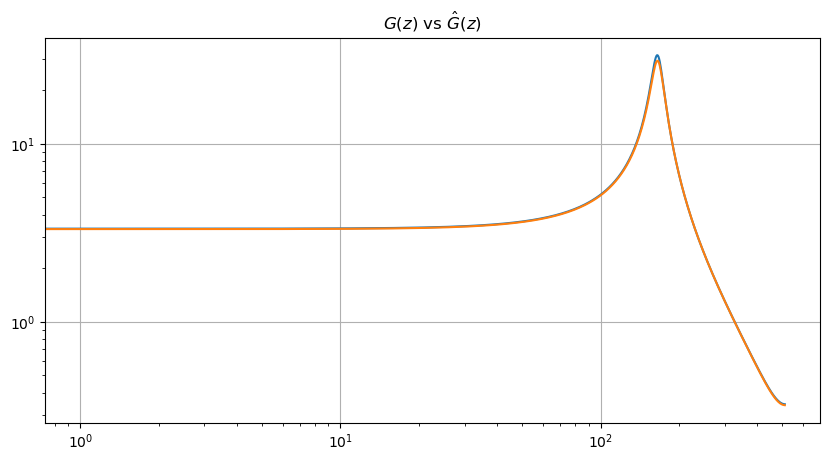

In [9]:
# recuperamos los coeficientes: 
# dividimos el numerador por b[0] para ajustar el cambio de ganancia originado por la normalización
numzest = clf.coef_[0][:2]/clf.coef_[0][0]
denzest = hstack((1, -clf.coef_[0][2:]))

from pylab import *
figure(1, figsize=(10,5))
loglog((abs(fft(numz,1024)/fft(denz,1024)))[:512])

loglog((abs(fft(numzest,1024)/fft(denzest,1024)))[:512])
grid(True)
title('$G(z)$ vs $\hat G(z)$')

print("coeficientes reales vs estimados")
print("numerador:   \t", numz, "\t numerador (estim):   ",numzest)
print("denominador: \t", denz, "\t denominador (estim): ",denzest)

Los resultados deben coincidir.

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Licencia de Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Ejemplo de Identificación de Sistemas</span> by <a xmlns:cc="http://creativecommons.org/ns#" href="http://isa.uniovi.es/~idiaz" property="cc:attributionName" rel="cc:attributionURL">Ignacio Díaz Blanco</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Reconocimiento-CompartirIgual 4.0 Internacional License</a>.